In [1]:
# Importo linrerias necesarias
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import det_curve
from sklearn.metrics import accuracy_score

In [5]:
# Preparo los datos
data = pd.read_csv('C:/Users/Universidad/Proyecto_ASMI/archivo_modificado_final.csv')

# Definir el umbral de no nulos
umbral = 0.90  

# Calcular el porcentaje de valores no nulos por columna
porcentaje_no_nulos = data.notnull().mean()

# Filtrar las columnas que cumplen con el umbral
columnas_filtradas = porcentaje_no_nulos[porcentaje_no_nulos > umbral].index

# Crear un nuevo DataFrame con solo esas columnas
df_filtrado = data[columnas_filtradas]

# Mostrar el resultado
print(df_filtrado.shape)

(7440, 63)


In [6]:
# Definir el umbral de no nulos
umbral_filas = 0.30  

# Calcular el número mínimo de valores no nulos requeridos por fila
min_no_nulos = int(umbral_filas * df_filtrado.shape[1])

# Eliminar las filas que no cumplen con el umbral
df_filtrado_filas = df_filtrado.dropna(thresh=min_no_nulos)

# Mostrar el resultado
print(df_filtrado_filas.shape)

(7440, 63)


In [7]:
# Saco la mediana de cada columna y la relleno en los valores nulos
df_filtrado_filas2 = df_filtrado_filas.drop(columns=['usuario'])
df_filtrado_filas2 = df_filtrado_filas2.fillna(df_filtrado_filas2.mean())
df_filtrado_filas2 = df_filtrado_filas2.round(2)

# Reemplazar los valores inf por nan
df_filtrado_filas2 = df_filtrado_filas2.replace([np.inf, -np.inf], np.nan)
# Reeemplazar los valores nan por la media de la columna
df_filtrado_filas2 = df_filtrado_filas2.fillna(df_filtrado_filas2.mean())

In [ ]:


# Separar características y etiquetas
X = df_filtrado_filas2.drop(columns=['usuario_num', 'muestra', 'sesion', 'digito']).values  # Todas las columnas excepto la tercera como características
y = df_filtrado_filas2.iloc[:, 1].values  # Segunda columna como etiqueta

# Normalizar características
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Codificar etiquetas
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Filtrar datos según la sesión
X_train = X[df_filtrado_filas2["sesion"] == 1]
y_train = y[df_filtrado_filas2["sesion"] == 1]

X_test = X[df_filtrado_filas2["sesion"] == 2]
y_test = y[df_filtrado_filas2["sesion"] == 2]

# Construir el modelo ANN
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Precisión en test: {test_acc * 100:.2f}%')

# Obtener predicciones de probabilidad
y_probs = model.predict(X_test)

# Obtener las predicciones del modelo
y_pred = np.argmax(model.predict(X_test), axis=1)

# Calcular la precisión de cada dígito
for i in range(10):
    # Filtrar los valores para el dígito i
    y_true_digit = (y_test == i)
    y_pred_digit = (y_pred == i)

    # Calcular precisión para ese dígito
    digit_accuracy = accuracy_score(y_true_digit, y_pred_digit)
    print(f'Precisión para el dígito {i}: {digit_accuracy * 100:.2f}%')

NameError: name 'usuario_num' is not defined

PermutationExplainer explainer: 101it [00:34,  2.89it/s]                         
C:\Users\BiDAlab\AppData\Local\Temp\ipykernel_14452\3085821565.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:100], feature_names=df_filtrado_filas2.drop(columns=['usuario_num', 'muestra', 'sesion', 'digito']).columns)


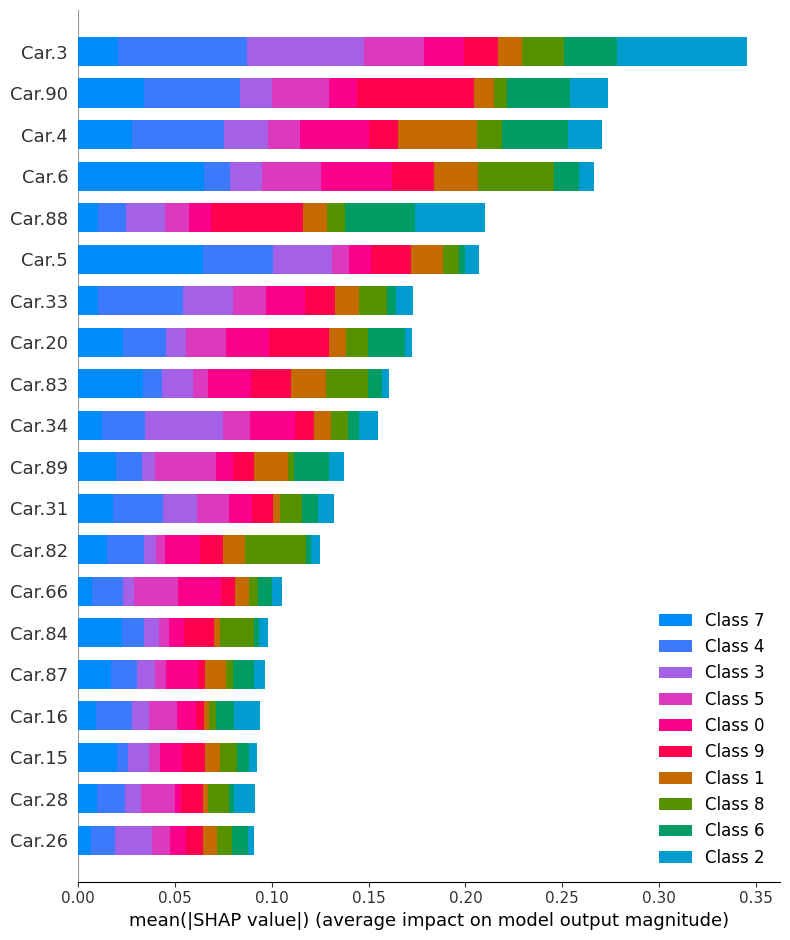

In [6]:
import shap

# Crear un explainer basado en el modelo entrenado
explainer = shap.Explainer(model, X_train)

# Obtener valores SHAP para las primeras 100 muestras (puedes aumentar)
shap_values = explainer(X_test[:100])

# Visualizar importancia de características
shap.summary_plot(shap_values, X_test[:100], feature_names=df_filtrado_filas2.drop(columns=['usuario_num', 'muestra', 'sesion', 'digito']).columns)
